# Physics-enhanced regression part 2

**Terminal-value data, and sampling with ``blackjax``.**

We create some fake-observational data, compute the marginal likelihood of this fake data _under the ODE posterior_ (which is something you cannot do with non-probabilistic solvers!), and sample from the posterior with `blackjax`. 

This assumes that you are  familiar with the first part of this tutorial.


In [1]:
import blackjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import solution_routines, solvers
from probdiffeq.doc_util import notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import filters

config.update("jax_enable_x64", True)

if not backend.has_been_selected:
    backend.select("jax")

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

Create some fake data by sampling a Lotka-Volterra solution with the incorrect initial value.

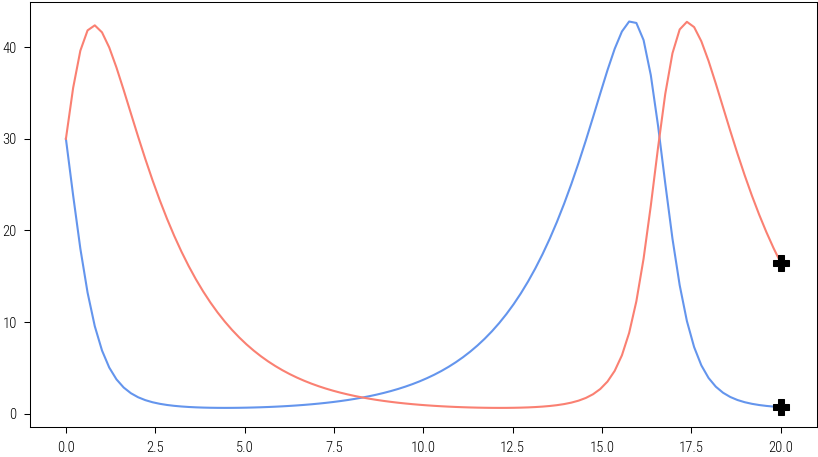

In [3]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()
f_args = jnp.asarray(f_args)

u0_true = u0 + 0.5 * jnp.flip(u0)
u0_guess = u0


@jax.jit
def vf(y, t, p):
    return f(y, *p)


ts = jnp.linspace(t0, t1, endpoint=True, num=100)

# Make a solver
strategy = filters.Filter(
    recipes.IsoTS0.from_params(num_derivatives=2),
)
solver = solvers.CalibrationFreeSolver(strategy, output_scale_sqrtm=10.0)

# Compute a bunch of solutions
solution_true = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0_true,), grid=ts, solver=solver, parameters=f_args
)
data = solution_true.u[-1, :]
plt.plot(ts, solution_true.u, "-")
plt.plot(ts[-1], data[None, :], "P", color="k", markersize=8)
plt.show()

Make a (poor) initial guess

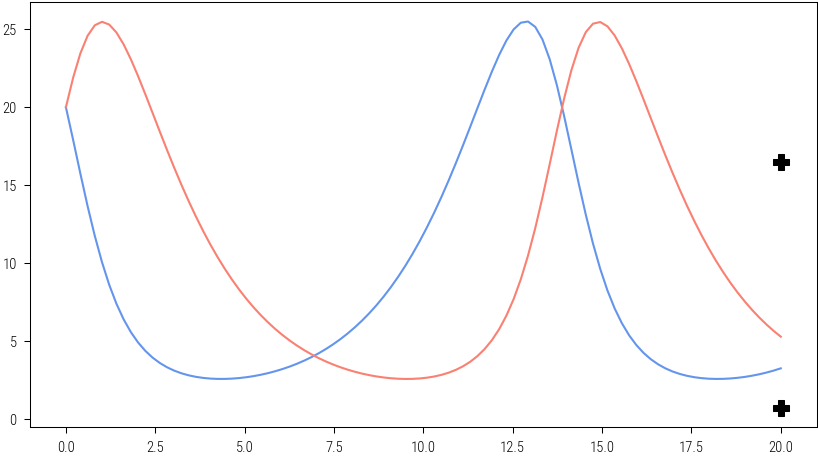

In [4]:
solution_guess = solution_routines.solve_fixed_grid(
    vf, initial_values=(u0_guess,), grid=ts, solver=solver, parameters=f_args
)
plt.plot(ts, solution_guess.u, "-")
plt.plot(ts[-1], data[None, :], "P", color="k", markersize=8)
plt.show()

Set up a logprob function to sample from: the likelihood of the data under the ODE posterior

In [5]:
def logprob_fn(u0):
    solution_guess = solution_routines.solve_fixed_grid(
        vf, initial_values=(u0,), grid=ts, solver=solver, parameters=f_args
    )
    posterior = solution_guess.posterior
    posterior_final = jax.tree_map(lambda x: x[-1], posterior)
    marginals, _ = posterior_final.condition_on_qoi_observation(
        data, observation_std=1e-4
    )
    return marginals.logpdf(data)

Set up a sampler

In [6]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

Initialise the sampler, warm it up, and run the inference loop.

In [7]:
initial_position = u0_guess
rng_key = jax.random.PRNGKey(0)

In [8]:
%%time

# WARMUP
warmup = blackjax.window_adaptation(
    blackjax.nuts, logprob_fn, num_steps=200, progress_bar=True
)
initial_state, nuts_kernel, _ = warmup.run(rng_key, initial_position)

Running window adaptation



CPU times: user 6.49 s, sys: 25.4 ms, total: 6.51 s
Wall time: 6.44 s


In [9]:
%%time

# INFERENCE LOOP
rng_key, _ = jax.random.split(rng_key, 2)
states = inference_loop(rng_key, nuts_kernel, initial_state, 200)

CPU times: user 4.81 s, sys: 0 ns, total: 4.81 s
Wall time: 4.76 s


Compute the ODE solution for all the samples and plot the results.

In [10]:
def u0_to_sol(u0):
    solution_guess = solution_routines.solve_fixed_grid(
        vf, initial_values=(u0,), grid=ts, solver=solver, parameters=f_args
    )
    return solution_guess.u


solutions = jax.vmap(u0_to_sol)(states.position)

initial = u0_to_sol(u0_guess)

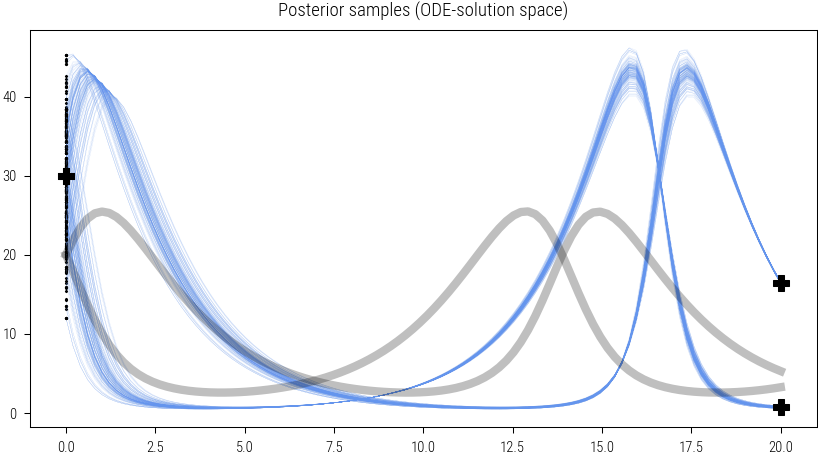

In [11]:
for sol in solutions:
    plt.plot(ts, sol, color="C0", linewidth=0.05, alpha=0.7, marker="None")
    plt.plot(ts[0], sol[0][None, :], "P", markersize=1, color="C0")
    plt.plot(ts[-1], sol[-1][None, :], "P", markersize=1, color="C0")


plt.title("Posterior samples (ODE-solution space)")
plt.plot(ts, initial, color="k", alpha=0.25, linewidth=4, marker="None")
plt.plot(ts[0], u0_true[None, :], "P", color="k", markersize=8)
plt.plot(ts[-1], data[None, :], "P", color="k", markersize=8)
# plt.ylim((0, 40))
plt.show()

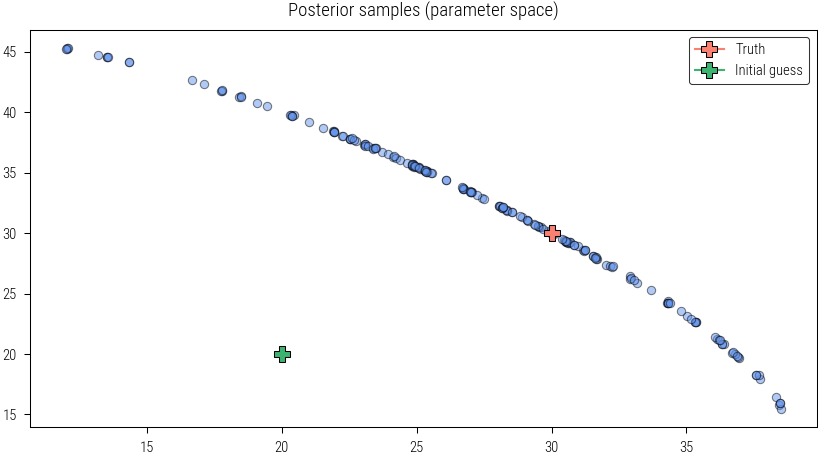

In [12]:
plt.title("Posterior samples (parameter space)")
plt.plot(states.position[:, 0], states.position[:, 1], "o", alpha=0.5, markersize=4)
plt.plot(u0_true[0], u0_true[1], "P-", label="Truth", markersize=8)
plt.plot(u0_guess[0], u0_guess[1], "P-", label="Initial guess", markersize=8)
plt.legend()
plt.show()

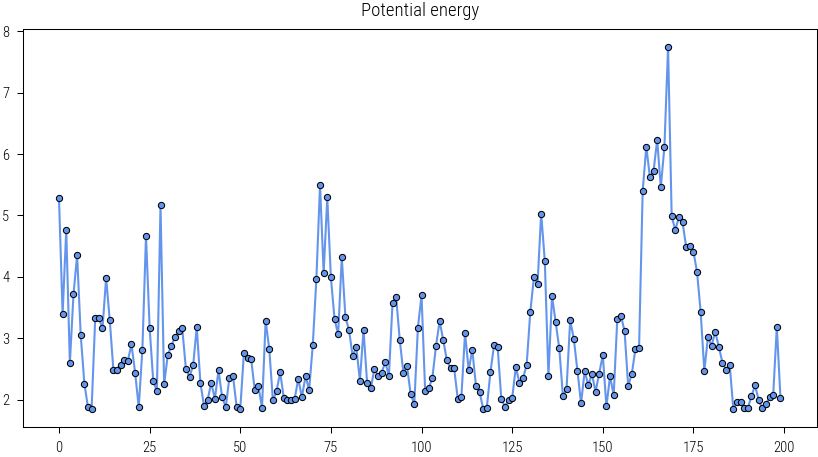

In [13]:
plt.title("Potential energy")
plt.plot(states.potential_energy, ".-")
plt.show()